## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

#  Import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [46]:
advertising = pd.read_csv('ab_data.csv')

In [47]:
advertising.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [48]:
advertising.shape[0]

294478

c. The number of unique users in the dataset.

In [49]:
advertising['user_id'].nunique()

290584

d. The proportion of users converted.

In [50]:
advertising['converted'].sum()/advertising['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [51]:
old_treat = advertising.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
new_control = advertising.query("group == 'control' and landing_page == 'new_page'").shape[0]

print(old_treat + new_control)

3893


f. Do any of the rows have missing values?

In [52]:
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [54]:
advertising2 = advertising.query("group == 'control' and landing_page == 'old_page'")
advertising2 = advertising2.append(advertising.query("group == 'treatment' and landing_page == 'new_page'"))

In [55]:
# Double Check all of the correct rows were removed - this should be 0
advertising2[((advertising2['group'] == 'treatment') == (advertising2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [56]:
advertising2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [57]:
advertising2[advertising2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [60]:
advertising2[advertising2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [61]:
advertising2 =advertising2.drop(2893)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [62]:
advertising2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [81]:
cont_prob = advertising2[advertising2['group'] == 'control'].converted.mean()
cont_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [63]:
treat_prob = advertising2[advertising2['group'] == 'treatment'].converted.mean()
treat_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [64]:
advertising2[advertising2['landing_page'] == 'new_page'].shape[0]/advertising2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

No, it doesn’t seem as that one page leads to more conversions. The new page led to a lower conversion rate than the old page, but the difference is negligible.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- H0:Pold=Pnew   // H0 : Pnew - Pold < = 0
- H1:Pnew>Pold 

or...

- H0 : Pnew - Pold < = 0
- H1:Pnew−Pold>0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [71]:
pn_null = advertising2['converted'].mean()
pn_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# both are equal
pn_null

0.11959708724499628

c. What is $n_{new}$?

In [67]:
num_new = advertising2.query("landing_page == 'new_page'").shape[0]
num_new

145310

d. What is $n_{old}$?

In [68]:
num_old = advertising2.query("landing_page == 'old_page'").shape[0]
num_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [72]:
converted_old_page = np.random.binomial(1, pn_null, num_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [73]:
converted_new_page = np.random.binomial(1, pn_null, num_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [74]:
new_page_converted.mean()- converted_old_page.mean()

-0.0015346500584956235

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [76]:
p_diffs = []
converted_new_simulation = np.random.binomial(num_new, pn_null, 10000)/num_new
converted_old_simulation = np.random.binomial(num_old, pn_null, 10000)/num_old
p_diffs = converted_new_simulation - converted_old_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 1.0, 'Simulated disribution of p_diffs under the Null')

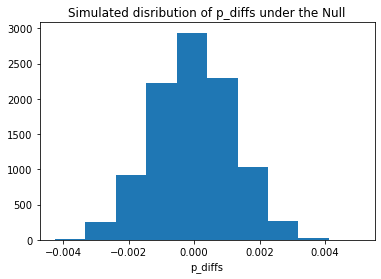

In [79]:
p_diffs_arr = np.array(p_diffs)
plt.hist(p_diffs_arr);
plt.xlabel('p_diffs')
plt.title('Simulated disribution of p_diffs under the Null')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.8998


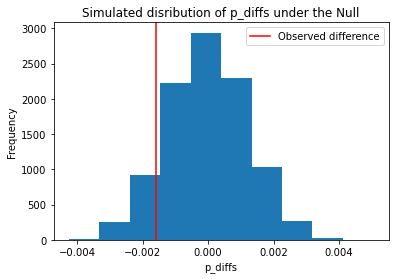

In [110]:
t_c_obs_diff = treat_prob - cont_prob

low_prob = (p_diffs > t_c_obs_diff).mean()
plt.hist(p_diffs);

plt.axvline(t_c_obs_diff, color='red', label="Observed difference");
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated disribution of p_diffs under the Null')
plt.legend()

print(low_prob)

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value is called the p-value. If it was under 0.05, it indicated a very low probability of, as the assuming the null hypothesis were true, finding a value equal to or significantly greater or lesser than obsdiff. I obtained the p-value for both directions because the alternative hypothesis ($P{new} \neq P_{old}$) is two-sided, meaning either a positive or negative value could apply.

it appears that the p-value is above 0.05, which means we do not have evidence to reject the null hypothesis ( Pnew=Pold ).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [83]:
import statsmodels.api as sm

converted_old = advertising2.query("landing_page == 'old_page'")['converted'].sum()
converted_new = advertising2.query("landing_page == 'new_page'")['converted'].sum() 


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [108]:
z_score, p_value = sm.stats.proportions_ztest([converted_old, converted_new], [num_old, num_new], alternative = 'smaller')

print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score means the difference between our test statistic (which is the difference between conversion rates) and the null hypothesis is 1.31 standard deviations above the mean. This is less than the critical 1.96. so, we need to reject the null hypothesis. the p-value here is 0.1899, which is above our alpha of 0.05. This p-value is similar to the previous p-value of 0.1998, so the z-test appears to agree with the previous findings.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

This is a logistic regression, since we want to know the odds of conversion, rather than a linear figure.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [85]:
advertising2['intercept'] = 1
advertising2[['a_page', 'ab_page']] = pd.get_dummies(advertising2['group'])
advertising2 = advertising2.drop('a_page', axis=1)
advertising2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [86]:
log_mod = sm.Logit(advertising2['converted'], advertising2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        14:47:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.190 here, which is similar to the previous values, but a litle higher. This model is attempting to predict if a user will convert depending on their page. The null hypothesis is when ab_page = 1 and converted = 0; the alternative hypothesis is when ab_page = 1 and converted is more likely to be 1.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It doesn’t appear that the treatment or control page has much impact on if a user converts. and so, it is probably a good idea to see whether other factors might predict conversion. It is important to be when selecting factors to make sure the factors are not in and of themselves colinear.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [88]:
countries = pd.read_csv('countries.csv')
countries.head()
holl_data = countries.set_index('user_id').join(advertising2.set_index('user_id'), how='inner')

In [89]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [90]:
holl_data.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [91]:
### Create the necessary dummy variables

holl_data[['CA', 'UK', 'US']] = pd.get_dummies(holl_data['country'])

In [92]:
holl_data.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [93]:
holl_data = holl_data.drop(columns =['country','US'], axis =1)

In [94]:
holl_data.head()

,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [95]:
### Fit Your Linear Model And Obtain the Results
holl_data['intercept'] = 1
logit_mod = sm.Logit(holl_data['converted'], holl_data[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:               2.323e-05
Time:                        14:52:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [96]:
holl_data.head() 
holl_data['CA_ab_page'] = holl_data.CA *holl_data.ab_page
holl_data['uk_ab_page'] = holl_data.UK *holl_data.ab_page
holl_data.head()

,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,CA_ab_page,uk_ab_page
user_id,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [97]:
holl_data['intercept'] = 1
lm = sm.Logit(holl_data['converted'],holl_data[['intercept','ab_page','CA',
                                                'CA_ab_page','UK','uk_ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [98]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:               3.482e-05
Time:                        14:53:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
uk_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

## conclusion on regression

The p_value is higher than 0.05 for both interaction terms.

The influence of landing_page in the CA is different alitle to the influence of landing_page in the other countries (UK).


<a id='conclusions'></a>
## Conclusions

Finally, there is no enough evidence refer that the new page will increase the conversion rate as to the old one. And that based on the probability figures, A/B test and regression.

No strong evidence that the countries affect the conversion.

Since the sample size is continuing the testing of the new_page with large amount is likely not necessary. It is best to focus on the development of another new landing page. 
